In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm as tqdm
import sys

tf.compat.v1.disable_eager_execution()

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

try:
    from rikabplotlib.plot_utils import newplot, stamp, add_whitespace
except:
    from utils.plot_utils import newplot, stamp, add_whitespace


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2024-03-13 00:41:01.112585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Num GPUs Available:  0
GPUs Available:  []


/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))


In [2]:
# Parameters 
train = 1
val = 10000
test = 10000

latent_dimension = 2
max_k = 4
epochs = 75
batch_size=512
callbacks =None
verbose = 2


input_dim = 2
output_dim = 1


F_width = 100
Phi_width = 100


def log_angularity(x):

    a = -3.5
    b = -1.0
    c = 0.005

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    return ls


def gaussian_angularity(x):

    a = 1
    b = 0.16
    c = 0.15

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.exp(- rs**2 / c **2)

    return ls


def moments(x, function_list):

    if len(function_list) > 2:
        print("Not implemented for L > 2")
        raise ValueError("Not implemented for L > 2")


    zs = x[:,0]
    ls_list = [func(x) for func in function_list]

    l_list = []
    for n in range(max_k + 1):

        if len(function_list) == 1:
            l_list.append(np.sum(zs * np.power(ls_list[0], n)))
        else:

            for power1 in range(n+1):
                power2 = n - power1
                l_list.append(np.sum(zs * np.power(ls_list[0], power1) * np.power(ls_list[1], power2)))


    return np.array(l_list)




def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.000

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(max_k + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return np.array(l_list)



def cumulants(x):

    x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 1))
    x[3,:] = np.nan_to_num(np.power(x[3,:] - 3*x[2,:]*x[1,:] + 2*x[1,:]**3, 1))
    x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 1))

    return x


def L_effective(L, k):
    return int(scipy.special.comb(L + k, k))


# Data 
def load_features():


    X, Y = qg_jets.load(train+val+test)

    print("Data loaded!")


    X = X[:,:,:3].astype(np.float32)
    Y2 = to_categorical(Y, num_classes=2)
    features = []
    for x in tqdm.tqdm(X):
        mask = x[:,0] > 0
        yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()

        if latent_dimension == 1:
            features.append((log_features(x)))
        else:
            features.append((moments(x, [log_angularity, gaussian_angularity])))

    features = np.array(features)

    return features, Y2

features, Y2 = load_features()
print("Features loaded!")
print(features.shape, features[0].shape)
print([L_effective(2, k) for k in range(5)])


Data loaded!


100%|██████████| 20001/20001 [00:04<00:00, 4490.15it/s]

Features loaded!
(20001, 15) (15,)
[1, 3, 6, 10, 15]


In [3]:
# rocs = []
# for k_order in [4]:

#     l_eff = L_effective(latent_dimension, k_order)

#     (X_train, X_val, X_test,
#     Y_train, Y_val, Y_test) = data_split(features[:,:l_eff], Y2, val=val, test=test)

#     dense_sizes = (100,100,100,1)

#     dnn = DNN(input_dim=l_eff, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='LeakyReLU')

#     # train model
#     dnn.fit(X_train, Y_train,
#             epochs=50,
#             batch_size=500,
#             validation_data=(X_val, Y_val),
#             verbose=1)

#     # get predictions on test data
#     preds = dnn.predict(X_test, batch_size=1000)
#     dnn.save_weights(f"Data_old/dnn/c0_O{k_order}_L{latent_dimension}.keras")


#     # get ROC curve if we have sklearn
#     if roc_curve:
#         rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

#         # save the ROC curve and AUC
#         fpr, tpr, _ = rocs[-1]
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         np.save(f"Data_old/dnn/linear_O{k_order}_L{latent_dimension}_roc.npy", (fpr, tpr, auc))
        

#         # get area under the ROC curve
#         auc = roc_auc_score(Y_test[:,1], preds[:,1])
#         print()
#         print('AUC:', auc)
#         print()


AUC: 0.7670466045055657


AUC: 0.8039183121290965


AUC: 0.8130638674620665


AUC: 0.8239007941641135



2024-03-13 00:41:12.659395: W tensorflow/c/c_api.cc:300] Operation '{name:'output/bias/Assign' id:297 op device:{requested: '', assigned: ''} def:{{{node output/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output/bias, output/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-03-13 00:41:12.842364: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_9/Sigmoid' id:303 op device:{requested: '', assigned: ''} def:{{{node activation_9/Sigmoid}} = 


AUC: 0.870608960773033



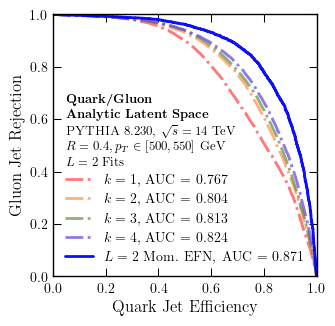

In [4]:
from energyflow.archs.moment import EFN_moment, PFN_moment
from energyflow.archs.moment_layers import Moment


fig, ax = newplot("column")

rocs = []
colors = ['red', 'orange', 'green', 'blue', 'purple', 'pink', "grey", "black"]

for i, k_order in enumerate([1, 2, 3, 4]):

    l_eff = L_effective(latent_dimension, k_order)

    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:l_eff], Y2, val=val, test=test)

    # dense_sizes = (100,100,1)

    # dnn = DNN(input_dim=l_eff, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')
    # dnn.load_weights(f"Data/dnn/linear_O{k_order}_L2.keras")


    # get predictions on test data

    # Load the ROC curve and AUC
    fpr, tpr, auc = np.load(f"Data_old/dnn/linear_O{k_order}_L{latent_dimension}_roc.npy", allow_pickle=True)


    # get ROC curve if we have sklearn
    rocs.append((fpr, tpr))

    # get area under the ROC curve
    # auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    # get rgb color from color name
    if colors[i] == "red":
        color = np.array((1, 0, 0))
    elif colors[i] == "orange":
        color = np.array((1, 0.5, 0))
    elif colors[i] == "green":
        color = np.array((0, 0.5, 0))
    elif colors[i] == "blue":
        color = np.array((0, 0, 1))

    magenta = np.array((1, .7, .7))
    magenta_weight = 0.75

    # mix color with magenta
    color = (magenta*magenta_weight + color) / (magenta_weight + 1)

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(rocs[i][1], 1-rocs[i][0], ls = 'dashdot', color = color, alpha = 0.75, label = l, lw = 2)




 ##### Original #####

X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3].astype(np.float32)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
p_train, p_val, p_test,
Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

dictionary = {'Phi_mapping_dim' : [2,latent_dimension],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [100, 100], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" : 1e-6,
                                        'F_sizes' : [100,100,100], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : 4 , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy',}
# moment_efn = EFN_moment(**dictionary, summary=False)

moment_efn = tf.keras.models.load_model(f"../MomentAnalysis2/Data/qg_EFN_latent2/order_4/Models/O4_L{latent_dimension}_2Phi100_3F100_0.keras", custom_objects={'Moment': Moment})

# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))


# # moment_efn.load_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras", by_name=True)
# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))

# # # initialize
# # moment_efn.fit(X_train, Y_train, epochs = 50)
# # moment_efn.save_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras")

preds = moment_efn.predict(X_test, batch_size=1000)

# print(preds.shape, Y_test.shape)

# get ROC curve if we have sklearn
rocs.append(roc_curve(Y_test, preds))
# np.save("roc", roc_curve(Y_test, preds))

# get area under the ROC curve
auc = roc_auc_score(Y_test, preds)
print()
print('AUC:', auc)
print()


plt.plot(rocs[-1][1], (1-rocs[-1][0]) , '-', color = "blue", alpha = 0.95, label = f"$L = {latent_dimension}$ Mom. EFN, AUC = {auc: .3f}", lw = 2)



# Stamp
line_0 = "Quark/Gluon"
line_1 = r"$\textbf{ Analytic Latent Space}$"
line_2 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_3 = "$R = 0.4, p_T \in [500, 550]$ GeV"
line_4 = f"$L = {latent_dimension}$ Fits"
stamp(0.05, 0.675, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, line_4 = line_4, textops_update={"fontsize": 9})


# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)


plt.savefig(f"Plots/analytic_auc_{latent_dimension}.pdf", bbox_inches='tight')
plt.show()





AUC: 0.7300852444767976


AUC: 0.7842477030355307


AUC: 0.8158039488431483


AUC: 0.8210013011574401


AUC: 0.835


AUC: 0.799



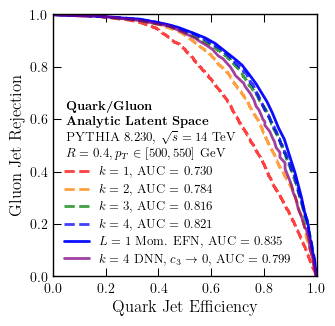

In [5]:
from energyflow.archs.moment import EFN_moment, PFN_moment
from energyflow.archs.moment_layers import Moment


fig, ax = newplot("column")

rocs = []
colors = ['red', 'orange', 'green', 'blue', 'purple', 'pink', "grey", "black"]

for i, k_order in enumerate([1, 2, 3, 4]):

    l_eff = L_effective(1, k_order)

    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:l_eff], Y2, val=val, test=test)

    # dense_sizes = (100,100,1)

    # dnn = DNN(input_dim=l_eff, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')
    # dnn.load_weights(f"Data/dnn/linear_O{k_order}_L2.keras")


    # get predictions on test data

    # Load the ROC curve and AUC
    fpr, tpr, auc = np.load(f"Data_old/dnn/linear_O{k_order}_L{1}_roc.npy", allow_pickle=True)


    # get ROC curve if we have sklearn
    rocs.append((fpr, tpr))

    # get area under the ROC curve
    # auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    # get rgb color from color name
    if colors[i] == "red":
        color = np.array((1, 0, 0))
    elif colors[i] == "orange":
        color = np.array((1, 0.5, 0))
    elif colors[i] == "green":
        color = np.array((0, 0.5, 0))
    elif colors[i] == "blue":
        color = np.array((0, 0, 1))

    magenta = np.array((1, .7, .7))
    magenta_weight = 0.0

    # mix color with magenta
    color = (magenta*magenta_weight + color) / (magenta_weight + 1)

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(rocs[i][1], 1-rocs[i][0], ls = '--', color = color, alpha = 0.75, label = l, lw = 2)




 ##### Original #####



# print(preds.shape, Y_test.shape)

# get ROC curve if we have sklearn
roc_curve_ = np.loadtxt(f"roc0.csv", delimiter = ",", unpack = True)
rocs.append(roc_curve_)
# np.save("roc", roc_curve(Y_test, preds))




# get area under the ROC curve
auc = 0.835
print()
print('AUC:', auc)
print()


plt.plot(rocs[-1][0], (rocs[-1][1]) , '-', color = "blue", alpha = 0.95, label = f"$L = {1}$ Mom. EFN, AUC = {0.835: .3f}", lw = 2)




# C = 0 Version
for i, k_order in enumerate([4]):

    l_eff = L_effective(latent_dimension, k_order)

    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:l_eff], Y2, val=val, test=test)

    # dense_sizes = (100,100,1)

    # dnn = DNN(input_dim=l_eff, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')
    # dnn.load_weights(f"Data/dnn/linear_O{k_order}_L2.keras")


    # get predictions on test data

    # Load the ROC curve and AUC
  # Load the fpr and tpr from 2 column csv file
    fpr, tpr = np.loadtxt(f"rocC0.csv", delimiter = ",", unpack = True)

    auc = 0.799

    # get ROC curve if we have sklearn
    rocs.append((fpr, tpr))

    # get area under the ROC curve
    # auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    # get rgb color from color name
    if colors[i] == "red":
        color = np.array((1, 0, 0))
    elif colors[i] == "orange":
        color = np.array((1, 0.5, 0))
    elif colors[i] == "green":
        color = np.array((0, 0.5, 0))
    elif colors[i] == "blue":
        color = np.array((0, 0, 1))

    magenta = np.array((1, .7, .7))
    magenta_weight = 0.0

    # mix color with magenta
    color = (magenta*magenta_weight + color) / (magenta_weight + 1)

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(fpr, tpr, ls = '-', color = "purple", alpha = 0.75, label = r"$k = 4$ DNN, $c_3 \to 0$," + f" AUC = %.3f" % auc, lw = 2)



# Stamp
line_0 = "Quark/Gluon"
line_1 = r"$\textbf{ Analytic Latent Space}$"
line_2 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_3 = "$R = 0.4, p_T \in [500, 550]$ GeV"
line_4 = f"$L = {latent_dimension}$ Fits"
stamp(0.05, 0.65, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"fontsize": 9})


# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False, fontsize = 9)


plt.savefig(f"Plots/analytic_auc.pdf", bbox_inches='tight')
plt.show()




In [6]:



# Parameters 
val = 5000
test = 5000
k_order = 4

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = 1
    b = 0.5
    c = 0.01

    zs = x[:,0]
    
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    ls = np.power(rs, 0.25)
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)



X, Y = qg_jets.load(train+val+test)
Y = to_categorical(Y, num_classes=2)
print("Data loaded!")


features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

features = np.array(features)
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(np.array(features), Y, val=val, test=test)




Data loaded!


In [7]:

dense_sizes = (100, 100, 100)
1, 2, 3, 
dnn = DNN(input_dim=4+1, dense_sizes=dense_sizes)

# train model
dnn.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)

angularity_rocs = []
# get ROC curve if we have sklearn
if roc_curve:
    angularity_rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_2 (Activation)   (None, 100)               0     

2024-03-13 00:41:19.847639: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_1_1/bias/v/Assign' id:1255 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1_1/bias/v, training/Adam/dense_1_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-03-13 00:41:19.966769: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:1100 op devic

1/1 [==============================] - 0s 16ms/sample - loss: 0.1141 - acc: 1.0000 - val_loss: 1.3110 - val_acc: 0.4972
Epoch 4/50
1/1 [==============================] - 0s 28ms/sample - loss: 0.0699 - acc: 1.0000 - val_loss: 1.4973 - val_acc: 0.4972
Epoch 5/50
1/1 [==============================] - 0s 18ms/sample - loss: 0.0439 - acc: 1.0000 - val_loss: 1.6812 - val_acc: 0.4972
Epoch 6/50
1/1 [==============================] - 0s 15ms/sample - loss: 0.0283 - acc: 1.0000 - val_loss: 1.8585 - val_acc: 0.4972
Epoch 7/50
1/1 [==============================] - 0s 18ms/sample - loss: 0.0188 - acc: 1.0000 - val_loss: 2.0286 - val_acc: 0.4972
Epoch 8/50
1/1 [==============================] - 0s 21ms/sample - loss: 0.0128 - acc: 1.0000 - val_loss: 2.1883 - val_acc: 0.4972
Epoch 9/50
1/1 [==============================] - 0s 20ms/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 2.3385 - val_acc: 0.4972
Epoch 10/50
1/1 [==============================] - 0s 21ms/sample - loss: 0.0065 - acc: 1.0000

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-03-13 00:41:21.105581: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_3/Softmax' id:1024 op device:{requested: '', assigned: ''} def:{{{node activation_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


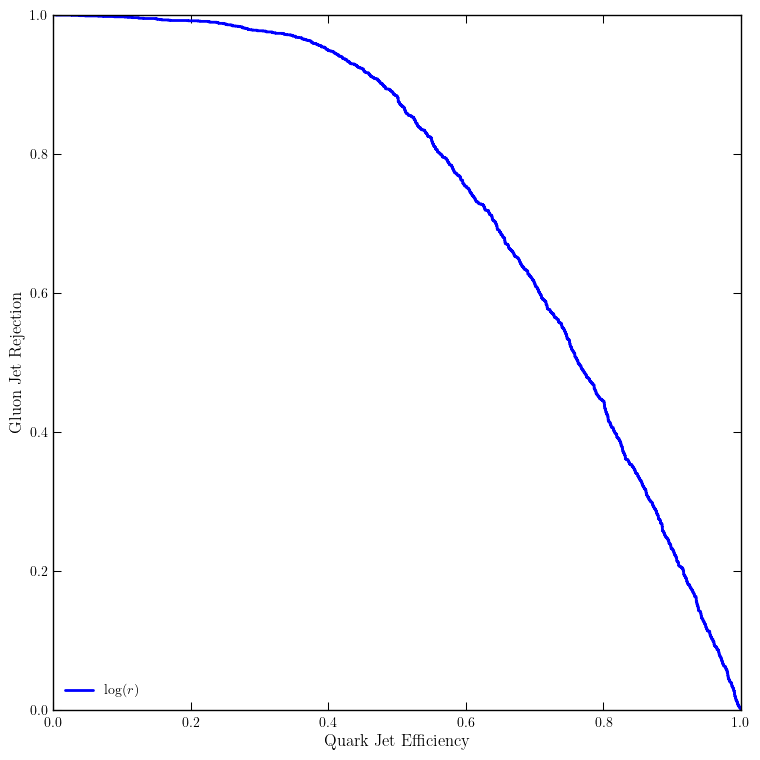

In [8]:
# some nicer plot settings 
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.autolayout'] = True

# iterate over the ROC curves and plot them
labels = ["~log$(r)$", "Angularities"]
colors = ["blue", "black"]
for i in range(len(angularity_rocs)):
    plt.plot(angularity_rocs[i][1], 1-angularity_rocs[i][0], '-', label = labels[i], lw = 2, color = colors[i])

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()